# COMP647 Assignment 03 - Mushroom Classification
## Student Name: Cruise Rong Zhou
## Student ID: 1162346
## Date: October 2025

---

## Assignment Overview
The goal is to classify mushrooms as edible or poisonous based on their physical characteristics.

---
By Answering these questions:

1.	Feature engineering and feature selection as appropriate to your dataset. Briefly explain and justify what you do using comments in your Python code.
2.	Use appropriate machine learning algorithms (supervised and/or unsupervised) to perform forecasting, classification or clustering tasks with respect to your dataset. Justify why the respective algorithms are selected.
3.	Conduct performance measures in the algorithm evaluations and justify the selected the performance measures would be the most appropriate to evaluate the algorithms chosen.
4.	Explain how you avoid over fitting and underfitting of the algorithms.
5.	Perform appropriate eXplainable AI techniques to discover which features are influencing the predictions.



## 1. Import Libraries and Load Data

In [53]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from category_encoders import BinaryEncoder

from imblearn.over_sampling import SMOTE


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

import shap
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier

print("All libraries imported done!")

All libraries imported done!


In [2]:
# Load the mushroom dataset
df = pd.read_csv('data/mushrooms.csv')

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())

Dataset Shape: (8124, 23)

First 5 rows:
  class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w               

## 2. Exploratory Data Analysis (EDA)

Target Variable Distribution:
class
e    4208
p    3916
Name: count, dtype: int64

Proportions:
class
e    0.517971
p    0.482029
Name: proportion, dtype: float64


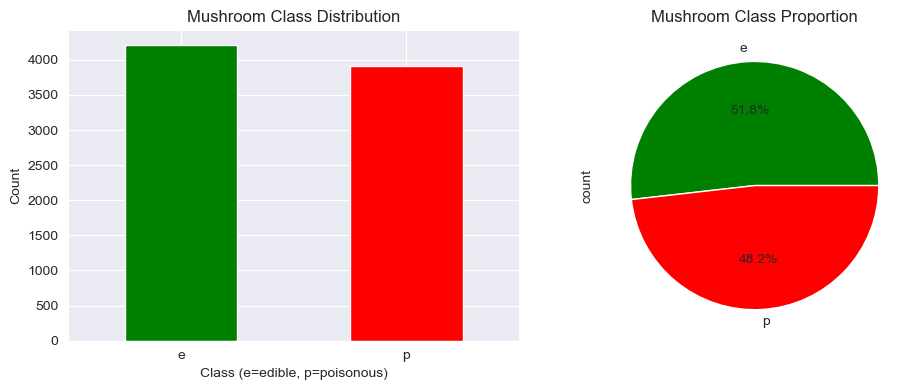

In [4]:
# Check target distribution (class is the variable identifying edible vs poisonous)
print("Target Variable Distribution:")
print(df['class'].value_counts())
print("\nProportions:")
print(df['class'].value_counts(normalize=True))

# plot class distribution
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
df['class'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Mushroom Class Distribution')
plt.xlabel('Class (e=edible, p=poisonous)')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
df['class'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['green', 'red'])
plt.title('Mushroom Class Proportion')

plt.tight_layout()
plt.show()

In [5]:
# Check for missing values
print("Missing Values Check:")
print(df.isnull().sum().sum(), "total missing values")

# Check for '?' which represents missing in this dataset
print("\nChecking for '?' values:")
for col in df.columns:
    if '?' in df[col].values:
        print(f"{col}: {(df[col] == '?').sum()} missing values")

Missing Values Check:
0 total missing values

Checking for '?' values:
stalk-root: 2480 missing values


## 3. Feature Engineering
### 3.1 Handle Missing Values

In [ ]:
# Replace '?' with the mode (most frequent value) for categorical data
df = df.replace('?', np.nan)

# Fill missing values with mode
for col in df.columns:
    if df[col].isnull().any():
        mode_value = df[col].mode()[0]
        df[col].fillna(mode_value, inplace=True)
        print(f"Filled {col} with mode: {mode_value}")

print("\nMissing values after imputation:", df.isnull().sum().sum())

### 3.2 Encoding Categorical Variables
According to lab sessions, I'll compare these three encoding methods:
   * Label Encoding
   * One-Hot Encoding
   * Binary Encoding

In [7]:
# extract features columns and target column
X = df.drop('class', axis=1)
y = df['class']

print("Features shape:", X.shape)
## it supposed to be all categorical features, rows: 8124, columns: 22

Features shape: (8124, 22)


In [8]:
# Method 1: Label Encoding
# Create a copy for label encoding
X_label_encoded = X.copy()

# Apply label encoding to all features
label_encoders = {}
for column in X_label_encoded.columns:
    le = LabelEncoder()
    X_label_encoded[column] = le.fit_transform(X_label_encoded[column])
    label_encoders[column] = le

# Encode target variable
y_encoder = LabelEncoder()
y_encoded = y_encoder.fit_transform(y)

print("Label Encoding done.")
print(f"Shape after label encoding: {X_label_encoded.shape}")
print(f"Target encoding: e={y_encoder.transform(['e'])[0]}, p={y_encoder.transform(['p'])[0]}")

Label Encoding completed
Shape after label encoding: (8124, 22)
Target encoding: e=0, p=1


In [10]:
# Method 2: One-Hot Encoding
# One-Hot Encoding is more appropriate for categorical data without ordinal relationship
X_one_hot = pd.get_dummies(X, drop_first=True)

print("One-Hot Encoding done.")
print(f"Shape after one-hot encoding: {X_one_hot.shape}")
print(f"Increased from {X.shape[1]} to {X_one_hot.shape[1]} features")

One-Hot Encoding done.
Shape after one-hot encoding: (8124, 95)
Increased from 22 to 95 features


In [54]:
# Method 3:  Binary Encoder
binary_encoder = BinaryEncoder(cols=X.columns.tolist())

# Fit and transform
X_binary_encoded = binary_encoder.fit_transform(X)

print("Binary Encoding Results:")
print(f"Shape: {X_binary_encoded.shape}")
print(f"Features created: {X_binary_encoded.shape[1]}")
print(f"Memory usage: {X_binary_encoded.memory_usage(deep=True).sum() / 1024:.2f} KB")
print(f"\nFeature names sample (first 10):")
print(list(X_binary_encoded.columns[:10]))



Binary Encoding Results:
Shape: (8124, 64)
Features created: 64
Memory usage: 4062.13 KB

Feature names sample (first 10):
['cap-shape_0', 'cap-shape_1', 'cap-shape_2', 'cap-surface_0', 'cap-surface_1', 'cap-surface_2', 'cap-color_0', 'cap-color_1', 'cap-color_2', 'cap-color_3']


### 3.3 Feature Scaling (Following Lab Methods)

In [55]:
# I'll use label encoded data for demonstration
# Method 1: Min-Max Scaling (scales to [0,1])
min_max_scaler = MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(X_label_encoded)
X_minmax = pd.DataFrame(X_minmax, columns=X_label_encoded.columns)

print("Min-Max Scaling done.")
print(f"Min value: {X_minmax.min().min():.2f}")
print(f"Max value: {X_minmax.max().max():.2f}")

Min-Max Scaling done.
Min value: 0.00
Max value: 1.00


In [12]:
# Method 2: Standard Scaling (z-score)
standard_scaler = StandardScaler()
X_standard = standard_scaler.fit_transform(X_label_encoded)
X_standard = pd.DataFrame(X_standard, columns=X_label_encoded.columns)

print("Standard Scaling done.")
print(f"Mean: {X_standard.mean().mean():.2f}")
print(f"Std: {X_standard.std().mean():.2f}")

Standard Scaling done.
Mean: -0.00
Std: 0.95


## 4. Feature Selection
### 4.1 Filter Methods - Chi-Square Test

Top 15 Features by Chi-Square Test:
                     Feature   Chi2_Score
8                 gill-color  5957.764469
18                 ring-type  1950.610146
7                  gill-size  1636.606833
3                    bruises  1194.277352
10                stalk-root  1186.029221
6               gill-spacing   826.795274
21                   habitat   751.309489
19         spore-print-color   379.132729
20                population   311.766736
11  stalk-surface-above-ring   222.982400
1                cap-surface   214.068544
12  stalk-surface-below-ring   206.648180
13    stalk-color-above-ring   119.792216
14    stalk-color-below-ring   109.789410
4                       odor    75.910163


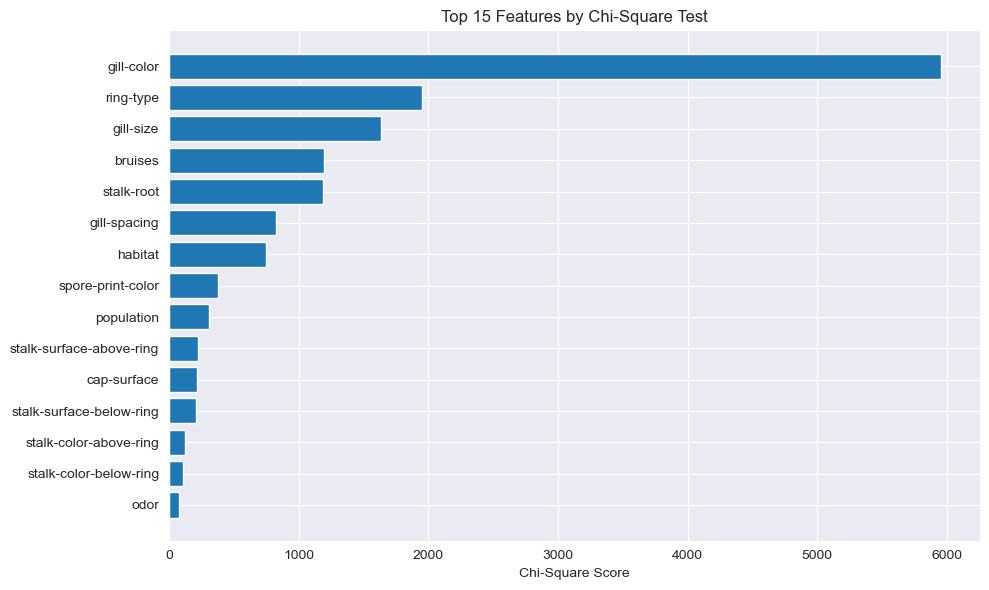

In [14]:
# Chi-square test for categorical features
# Using label encoded features (all non-negative)
topK = 15
chi2_selector = SelectKBest(score_func=chi2, k=topK)
X_chi2_selected = chi2_selector.fit_transform(X_label_encoded, y_encoded)

# Get selected feature names
selected_features_chi2 = X_label_encoded.columns[chi2_selector.get_support()].tolist()

# Get chi2 scores
chi2_scores = pd.DataFrame({
    'Feature': X_label_encoded.columns,
    'Chi2_Score': chi2_selector.scores_
}).sort_values('Chi2_Score', ascending=False)

print("Top 15 Features by Chi-Square Test:")
print(chi2_scores.head(topK))

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(chi2_scores['Feature'].head(topK), chi2_scores['Chi2_Score'].head(topK))
plt.xlabel('Chi-Square Score')
plt.title('Top 15 Features by Chi-Square Test')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 4.2 Filter Methods - ANOVA F-test

In [15]:
# Appliying ANOVA F-test
anova_selector = SelectKBest(score_func=f_classif, k=10)
X_anova_selected = anova_selector.fit_transform(X_label_encoded, y_encoded)

# Get selected features
selected_features_anova = X_label_encoded.columns[anova_selector.get_support()].tolist()

print("Selected Features by ANOVA:")
print(selected_features_anova)

Selected Features by ANOVA:
['bruises', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'ring-type', 'population', 'habitat']


### 4.3 Embedded Method - Random Forest Feature Importance

In [17]:
# Random Forest Feature Importance
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_label_encoded, y_encoded)

importances = pd.Series(rf_selector.feature_importances_, index=X_label_encoded.columns)
importances = importances.sort_values(ascending=False)

print("Top Features by Random Forest Importance:")
print(importances.head(10))

# Select features above threshold
threshold = 0.03
selected_features_rf = importances[importances > threshold].index.tolist()
print(f"\nSelected {len(selected_features_rf)} features with importance > {threshold}")

Top Features by Random Forest Importance:
odor                        0.180079
gill-color                  0.110174
spore-print-color           0.104880
gill-size                   0.098703
ring-type                   0.068237
stalk-root                  0.065057
population                  0.059439
stalk-surface-above-ring    0.052854
bruises                     0.051703
habitat                     0.032999
dtype: float64

Selected 12 features with importance > 0.03


## 5. Class Balancing with SMOTE

In [18]:
# Check class balance
class_counts = pd.Series(y_encoded).value_counts()
print("Class distribution:")
print(class_counts)
print(f"\nClass ratio: {class_counts[0]/class_counts[1]:.2f}:1")


X_selected = X_label_encoded[selected_features_chi2]

# Split data first
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Class distribution:
0    4208
1    3916
Name: count, dtype: int64

Class ratio: 1.07:1

Training set shape: (6499, 15)
Test set shape: (1625, 15)


In [19]:
# Apply SMOTE to training data only (as taught in labs)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("After SMOTE:")
print(f"Training set shape: {X_train_balanced.shape}")
print(f"Class distribution: {pd.Series(y_train_balanced).value_counts()}")

After SMOTE:
Training set shape: (6732, 15)
Class distribution: 1    3366
0    3366
Name: count, dtype: int64


## 6. Supervised Learning
### 6.1 Define and Train Multiple Models

In [21]:
# Define models together and ready for traiing and evaluation

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=67), # Liner Methods (simple, interpretable)
    'Decision Tree': DecisionTreeClassifier(random_state=67), # Tree-based (Handle Nonlinearities, Interactions)
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=67), # Ensemble Methods (improve accuracy, reduce overfitting)
    'KNN': KNeighborsClassifier(n_neighbors=5), # Instance-based (memory-based, distance-driven)
    'SVM': SVC(kernel='rbf', random_state=67), #  Kernel-Based Methods (high-dimensional boundaries)
    'Naive Bayes': GaussianNB() # Probabilistic Methods (based on likelihoods)
}

# Train and evaluate each model
results = []

for name, model in models.items():
    # Train on balanced data
    model.fit(X_train_balanced, y_train_balanced)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })
    
    print(f"{name}: Accuracy={accuracy:.4f}, F1={f1:.4f}")

Logistic Regression: Accuracy=0.9502, F1=0.9481
Decision Tree: Accuracy=1.0000, F1=1.0000
Random Forest: Accuracy=1.0000, F1=1.0000
KNN: Accuracy=1.0000, F1=1.0000
SVM: Accuracy=0.9895, F1=0.9891
Naive Bayes: Accuracy=0.8923, F1=0.8802



Model Performance Comparison:
              Model  Accuracy  Precision   Recall  F1-Score
      Decision Tree  1.000000   1.000000 1.000000  1.000000
      Random Forest  1.000000   1.000000 1.000000  1.000000
                KNN  1.000000   1.000000 1.000000  1.000000
                SVM  0.989538   0.994832 0.983397  0.989082
Logistic Regression  0.950154   0.951157 0.945083  0.948110
        Naive Bayes  0.892308   0.948378 0.821201  0.880219


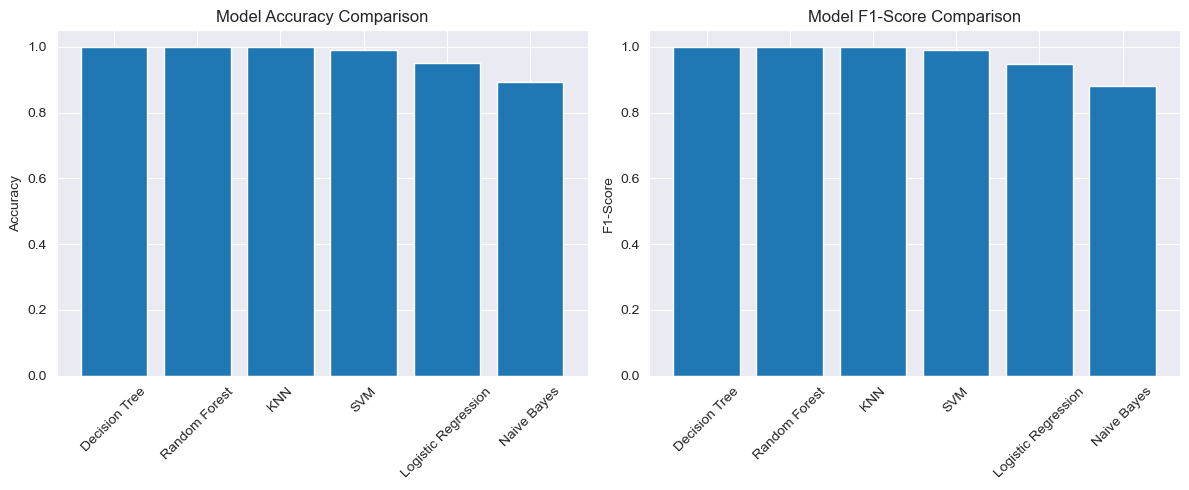

In [23]:
# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1-Score', ascending=False)

print("\nModel Performance Comparison:")
print(results_df.to_string(index=False))

# Visualise
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy comparison
axes[0].bar(results_df['Model'], results_df['Accuracy'])
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_ylabel('Accuracy')
axes[0].tick_params(axis='x', rotation=45)

# F1-Score comparison
axes[1].bar(results_df['Model'], results_df['F1-Score'])
axes[1].set_title('Model F1-Score Comparison')
axes[1].set_ylabel('F1-Score')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 6.2 Hyperparameter Optimisation

In [24]:
# As we can see the model evaluation, Random Forest is the best preforming model, so I choose to apply hyperparameter tuning on it.

# from labs
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_balanced, y_train_balanced)

print("Best parameters found:")
print(grid_search.best_params_)
print(f"\nBest cross-validation F1-score: {grid_search.best_score_:.4f}")

# Test model
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)
print(f"Test set F1-score: {f1_score(y_test, y_pred_best):.4f}")

Best parameters found:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Best cross-validation F1-score: 1.0000
Test set F1-score: 1.0000


### 6.3  Detect Overfitting (Cross-Validation)

In [26]:
# Perform cross-validation to check for overfitting

print("Cross-Validation Analysis for Overfitting Detection:")
print("="*50)

for name, model in models.items():
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
    
    # Training accuracy
    model.fit(X_train_balanced, y_train_balanced)
    train_score = model.score(X_train_balanced, y_train_balanced)
    
    # Test accuracy
    test_score = model.score(X_test, y_test)
    
    print(f"\n{name}:")
    print(f"  CV Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  Training: {train_score:.4f}")
    print(f"  Testing: {test_score:.4f}")
    
    # Check for overfitting
    if train_score - test_score > 0.1:
        print("  [DETECTED] Potential overfitting detected")
    else:
        print("   No significant overfitting")

    # all models are not detect  overfitting

Cross-Validation Analysis for Overfitting Detection:

Logistic Regression:
  CV Mean: 0.9381 (+/- 0.0038)
  Training: 0.9400
  Testing: 0.9502
   No significant overfitting

Decision Tree:
  CV Mean: 1.0000 (+/- 0.0000)
  Training: 1.0000
  Testing: 1.0000
   No significant overfitting

Random Forest:
  CV Mean: 1.0000 (+/- 0.0000)
  Training: 1.0000
  Testing: 1.0000
   No significant overfitting

KNN:
  CV Mean: 0.9970 (+/- 0.0017)
  Training: 1.0000
  Testing: 1.0000
   No significant overfitting

SVM:
  CV Mean: 0.9865 (+/- 0.0011)
  Training: 0.9874
  Testing: 0.9895
   No significant overfitting

Naive Bayes:
  CV Mean: 0.8895 (+/- 0.0056)
  Training: 0.8887
  Testing: 0.8923
   No significant overfitting


## 7. Unsupervised Learning
### 7.1 K-Means Clustering

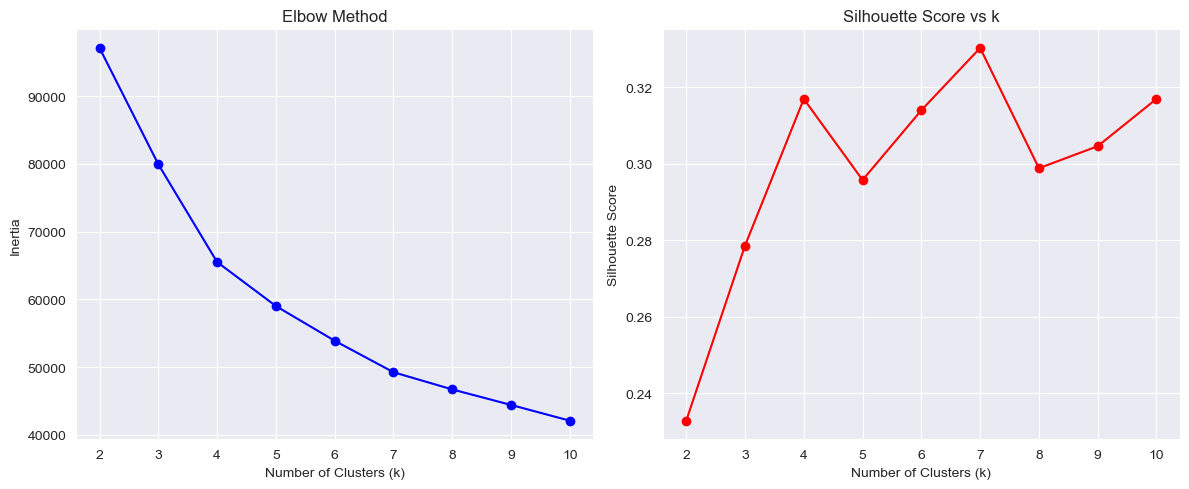

In [27]:
# Apply K-Means clustering
# Scale the data first (important for clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Determine optimal number of clusters using elbow method
inertias = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot elbow curve
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(K, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].grid(True)

axes[1].plot(K, silhouette_scores, 'ro-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score vs k')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [28]:
# Apply K-Means with k=2 (based on mushroom classification only has two classes)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Compare with true labels
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(y_encoded, cluster_labels)
print(f"Adjusted Rand Index: {ari:.4f}")

# Create confusion matrix
cluster_confusion = pd.crosstab(cluster_labels, y_encoded,
                               rownames=['Cluster'], colnames=['True Class'])
print("\nCluster vs True Label:")
print(cluster_confusion)

Adjusted Rand Index: 0.1848

Cluster vs True Label:
True Class     0     1
Cluster               
0           4046  2152
1            162  1764


### 7.2 PCA for Dimensionality Reduction

Components needed for 95% variance: 12
Reduction from 15 to 12 features


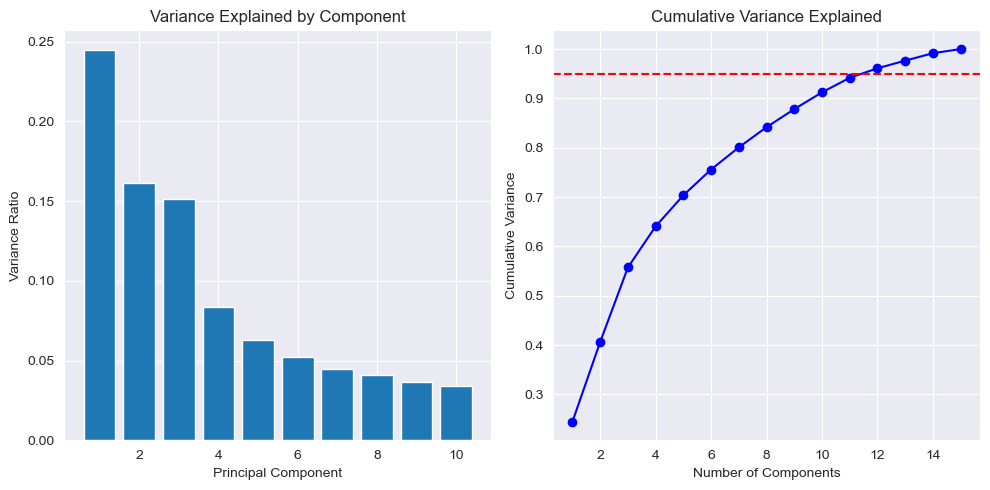

In [29]:
# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculate cumulative variance explained
cumsum_var = np.cumsum(pca.explained_variance_ratio_)

# Find number of components for 95% variance
n_components_95 = np.argmax(cumsum_var >= 0.95) + 1

print(f"Components needed for 95% variance: {n_components_95}")
print(f"Reduction from {X_scaled.shape[1]} to {n_components_95} features")

# Visualize variance explained
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(range(1, 11), pca.explained_variance_ratio_[:10])
plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio')
plt.title('Variance Explained by Component')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumsum_var)+1), cumsum_var, 'bo-')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.title('Cumulative Variance Explained')

plt.tight_layout()
plt.show()

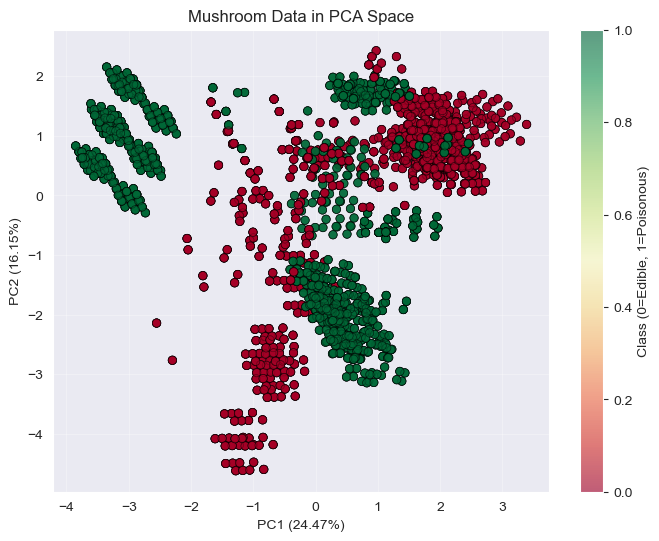

In [30]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded,
                     cmap='RdYlGn', alpha=0.6, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Class (0=Edible, 1=Poisonous)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.title('Mushroom Data in PCA Space')
plt.grid(True, alpha=0.3)
plt.show()

## 8. eXplainable AI
### 8.1 Permutation Importance

Calculating Permutation Importance (random forest)...

Top Features by Permutation Importance:
                     Feature  Importance       Std
4                  gill-size    0.042523  0.002813
2                       odor    0.008923  0.002823
1                    bruises    0.002954  0.000985
12         spore-print-color    0.001969  0.000862
14                   habitat    0.001723  0.000663
5                 gill-color    0.000738  0.000536
13                population    0.000615  0.000550
9     stalk-color-above-ring    0.000123  0.000246
10    stalk-color-below-ring    0.000062  0.000185
0                cap-surface    0.000000  0.000000
3               gill-spacing    0.000000  0.000000
6                 stalk-root    0.000000  0.000000
7   stalk-surface-above-ring    0.000000  0.000000
8   stalk-surface-below-ring    0.000000  0.000000
11                 ring-type    0.000000  0.000000


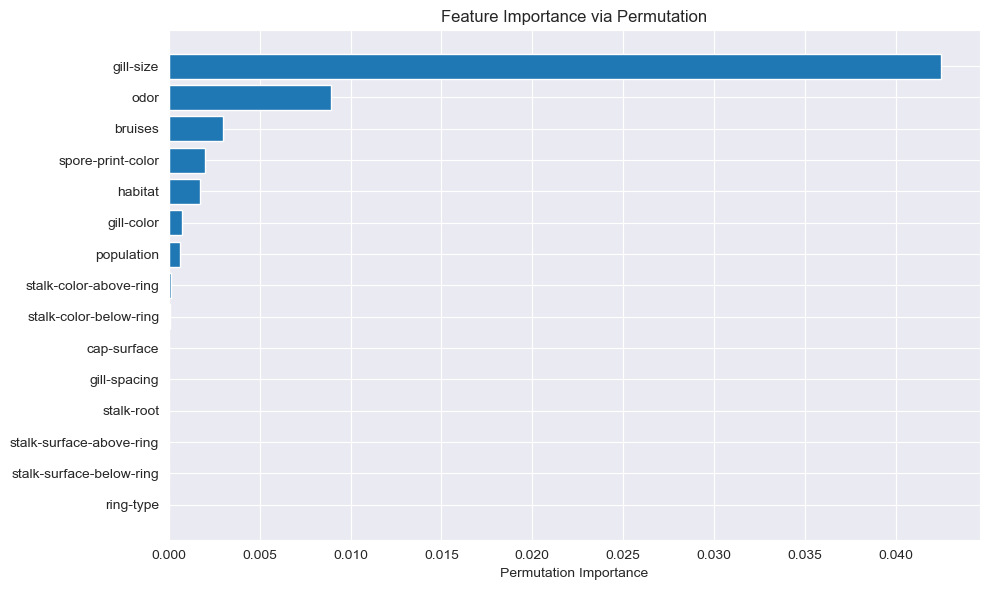

In [31]:
# Still choose Random Forest as the example.
print("Calculating Permutation Importance (random forest)...\n")

perm_importance = permutation_importance(
    best_rf, X_test, y_test,
    n_repeats=10, random_state=42
)

# Create dataframe for visualization
perm_imp_df = pd.DataFrame({
    'Feature': X_selected.columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)

print("Top Features by Permutation Importance:")
print(perm_imp_df)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(perm_imp_df['Feature'], perm_imp_df['Importance'])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance via Permutation')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 8.2 SHAP Analysis

 SHAP Analysis...



<Figure size 1000x600 with 0 Axes>

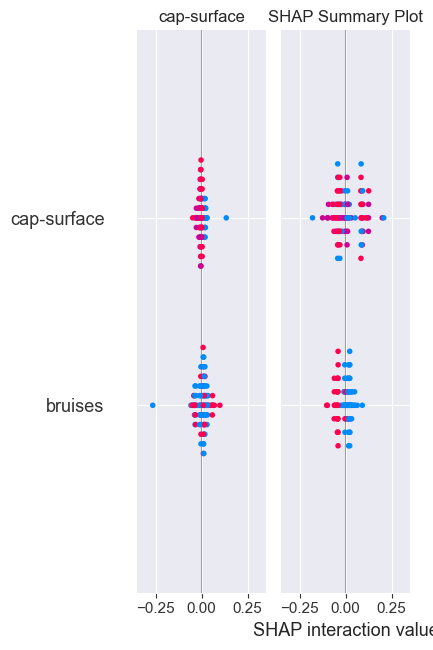

In [57]:
# SHAP for Random Forest
print(" SHAP Analysis...\n")

shap.initjs()


# Create SHAP explainer
explainer = shap.TreeExplainer(best_rf)

# Calculate SHAP values for test set (use subset for speed)
X_test_sample = X_test.iloc[:100]
shap_values = explainer.shap_values(X_test_sample)

# For binary classification, use class 1 (poisonous)
if isinstance(shap_values, list):
    shap_values = shap_values[1]

# SHAP Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_sample, show=False)
plt.title('SHAP Summary Plot')
plt.tight_layout()
plt.show()

In [58]:
# SHAP Feature Importance Bar Plot
shap_importance = np.abs(shap_values).mean(axis=0)
shap_imp_df = pd.DataFrame({
    'Feature': X_selected.columns,
    'SHAP_Importance': shap_importance
}).sort_values('SHAP_Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(shap_imp_df['Feature'], shap_imp_df['SHAP_Importance'])
plt.xlabel('Mean |SHAP Value|')
plt.title('Feature Importance by SHAP')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

ValueError: Per-column arrays must each be 1-dimensional

In [59]:
# SHAP Waterfall plot for a single prediction
# Explain why a specific mushroom was classified as poisonous
sample_idx = 0

plt.figure(figsize=(10, 6))
shap.waterfall_plot(
    shap.Explanation(values=shap_values[sample_idx],
                     base_values=explainer.expected_value[1],
                     data=X_test_sample.iloc[sample_idx],
                     feature_names=X_selected.columns.tolist()),
    show=False
)
plt.title(f'SHAP Explanation for Sample {sample_idx}')
plt.tight_layout()
plt.show()

# Print prediction details
prediction = best_rf.predict(X_test_sample.iloc[[sample_idx]])[0]
probability = best_rf.predict_proba(X_test_sample.iloc[[sample_idx]])[0]
true_label = y_test.iloc[sample_idx]

print(f"\nSample {sample_idx} Prediction Details:")
print(f"True Label: {'Poisonous' if true_label == 1 else 'Edible'}")
print(f"Predicted: {'Poisonous' if prediction == 1 else 'Edible'}")
print(f"Probability: {probability[1]:.2%} poisonous")

ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (15, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.


Model Safety concerns (False-negative matters in mushroom classfications):
              precision    recall  f1-score   support

      Edible       1.00      1.00      1.00       842
   Poisonous       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



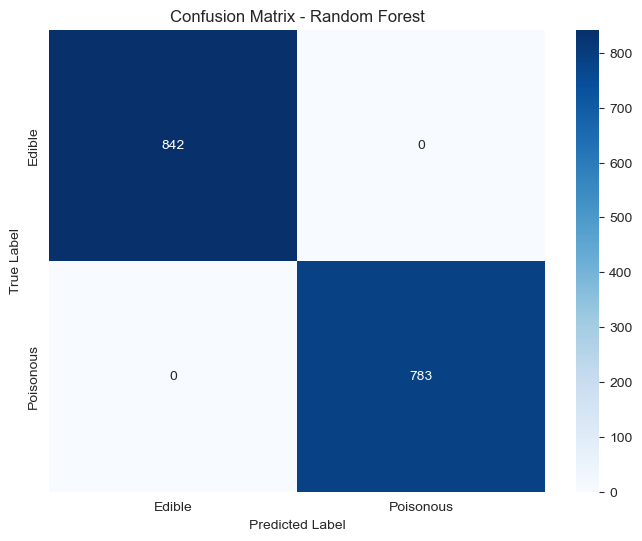

False Negatives (Dangerous): 0
False Positives (Conservative): 0

 No false negatives.


In [64]:
# Detailed evaluation of the best model
y_pred_final = best_rf.predict(X_test)

print("\nModel Safety concerns (False-negative matters in mushroom classfications):")
print(classification_report(y_test, y_pred_final,
                           target_names=['Edible', 'Poisonous']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Edible', 'Poisonous'],
            yticklabels=['Edible', 'Poisonous'])
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Safety Analysis
false_negatives = cm[1, 0]  # Poisonous predicted as edible (DANGEROUS)
false_positives = cm[0, 1]  # Edible predicted as poisonous (SAFE but wasteful)

print(f"False Negatives (Dangerous): {false_negatives}")
print(f"False Positives (Conservative): {false_positives}")

if false_negatives > 0:
    print("\n @@@!!!: Model has false negatives!")
    print("This means some poisonous mushrooms were classified as edible.")
    print("DO NOT use this model for actual mushroom identification!")
else:
    print("\n No false negatives.")